In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import os
import cv2 
from pathlib import Path
from tqdm import tqdm
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, 
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
    roc_curve
)
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

In [2]:
# 1. Set the folder path
# --------------------------------------------------
train_REAL = "data/train/REAL"
train_FAKE = "data/train/FAKE"
test_REAL = "data/test/REAL"
test_FAKE = "data/test/FAKE"

In [3]:
# 2. DATA LOADING AND PREPARATION
# --------------------------------------------------
def load_images_from_folder(folder, label):
    """
    Loads all images from a given folder, resizes them to 32x32,
    and assigns a specified label.
    """
    images = []
    labels = []
    if not os.path.isdir(folder):
        print(f"Warning: Directory not found at {folder}")
        return np.array([]), np.array([])
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        
        if img is not None:
            img = cv2.resize(img, (32, 32))
            images.append(img)
            labels.append(label)
    return np.array(images), np.array(labels)

print("Loading training data...")
train_real_images, train_real_labels = load_images_from_folder(train_REAL, 1)
train_fake_images, train_fake_labels = load_images_from_folder(train_FAKE, 0)

print("Loading testing data...")
test_real_images, test_real_labels = load_images_from_folder(test_REAL, 1)
test_fake_images, test_fake_labels = load_images_from_folder(test_FAKE, 0)

X_train = np.concatenate((train_real_images, train_fake_images), axis=0)
y_train = np.concatenate((train_real_labels, train_fake_labels), axis=0)
X_test = np.concatenate((test_real_images, test_fake_images), axis=0)
y_test = np.concatenate((test_real_labels, test_fake_labels), axis=0)

train_indices = np.arange(X_train.shape[0])
np.random.shuffle(train_indices)
X_train = X_train[train_indices]
y_train = y_train[train_indices]

test_indices = np.arange(X_test.shape[0])
np.random.shuffle(test_indices)
X_test = X_test[test_indices]
y_test = y_test[test_indices]

print(f"\nTraining data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Loading training data...
Loading testing data...

Training data shape: (100000, 32, 32, 3)
Testing data shape: (20000, 32, 32, 3)


In [4]:
X_train_normalized = X_train.astype('float32') / 255.0
X_test_normalized = X_test.astype('float32') / 255.0
X_train_flat = X_train_normalized.reshape(100000, -1)
X_test_flat = X_test_normalized.reshape(20000, -1)

In [5]:
X_train_flat.shape

(100000, 3072)

In [6]:
TRAIN_SIZE = 10000
TEST_SIZE = 2000
X_train_reduced, _, y_train_reduced, _ = train_test_split(
    X_train_flat, y_train,
    train_size=TRAIN_SIZE,
    stratify=y_train,
    random_state=42
)

X_test_reduced, _, y_test_reduced, _ = train_test_split(
    X_test_flat, y_test,
    train_size=TEST_SIZE,
    stratify=y_test,
    random_state=42
)

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_reduced)


In [8]:
%%time
# Fit PCA with maximum components (or reasonable subset)
pca_100 = PCA(n_components=100)  # Using 500 instead of 3072 for speed
pca_100.fit(X_train_scaled)

CPU times: user 19.6 s, sys: 127 ms, total: 19.7 s
Wall time: 2.73 s


PCA(n_components=100)

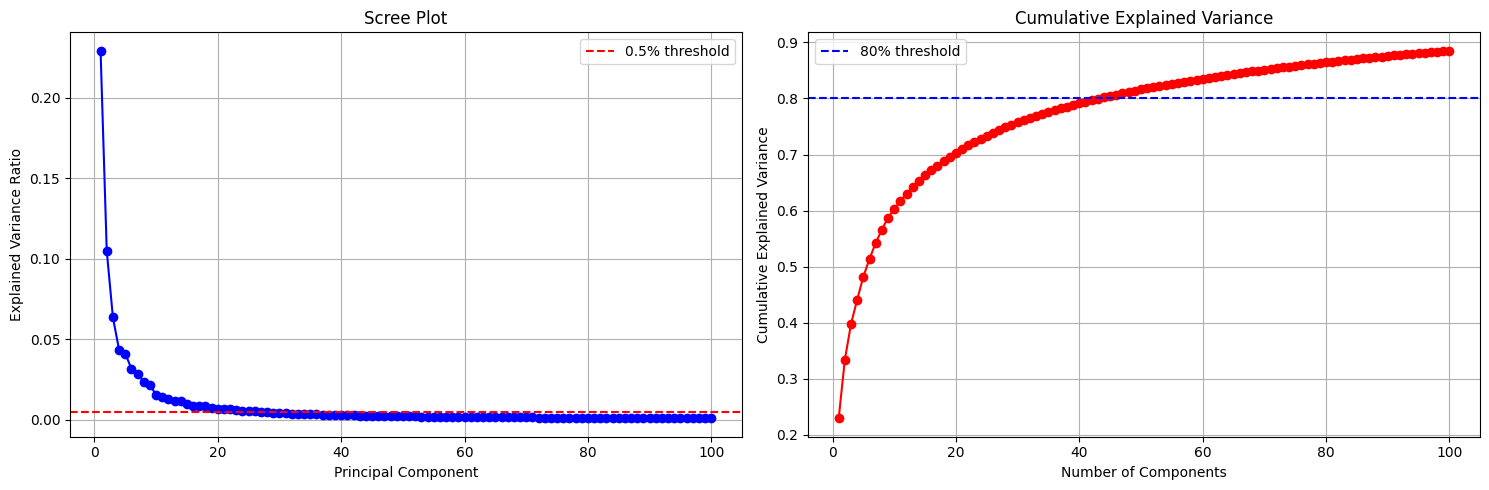

In [9]:
# Calculate cumulative explained variance
explained_variance = pca_100.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Scree plot (elbow method)
axes[0].plot(range(1, len(explained_variance) + 1), explained_variance, 'bo-')
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance Ratio')
axes[0].set_title('Scree Plot')
axes[0].grid(True)
axes[0].axhline(y=0.005, color='r', linestyle='--', label='0.5% threshold')
axes[0].legend()

# Plot 2: Cumulative explained variance
axes[1].plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'ro-')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Explained Variance')
axes[1].set_title('Cumulative Explained Variance')
axes[1].axhline(y=0.80, color='b', linestyle='--', label='80% threshold')
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()

In [10]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=40, random_state=42)),
    ('svm', SVC(kernel='rbf'))
])

param_grid = {
    'svm__C': [1.0, 10.0, 100.0],
    'svm__gamma': ['scale', 'auto']
}
grid_search = GridSearchCV(pipeline, param_grid, cv=3, 
                           scoring='accuracy', n_jobs=-1, verbose=2)

In [11]:
X_train_reduced.shape, X_test_reduced.shape

((10000, 3072), (2000, 3072))

In [12]:
%%time
print("\nTraining...")
grid_search.fit(X_train_reduced, y_train_reduced)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV score: {grid_search.best_score_:.3f}")



Training...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best parameters: {'svm__C': 1.0, 'svm__gamma': 'scale'}
Best CV score: 0.765
CPU times: user 19.3 s, sys: 877 ms, total: 20.2 s
Wall time: 1min 13s


In [13]:
# Evaluate on train set
train_score = grid_search.score(X_train_reduced, y_train_reduced)
print(f"Train accuracy: {train_score:.3f}")

# Evaluate on test set
test_score = grid_search.score(X_test_reduced, y_test_reduced)
print(f"Test accuracy: {test_score:.3f}")

Train accuracy: 0.844
Test accuracy: 0.781


In [14]:
y_train_pred = grid_search.predict(X_train_reduced)
y_test_pred = grid_search.predict(X_test_reduced)

In [15]:
class_names = ['Fake', 'Real']

In [16]:
print(classification_report(y_train_reduced, y_train_pred, target_names=class_names))

              precision    recall  f1-score   support

        Fake       0.85      0.84      0.84      5000
        Real       0.84      0.85      0.84      5000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



In [17]:
print(classification_report(y_test_reduced, y_test_pred, target_names=class_names))

              precision    recall  f1-score   support

        Fake       0.79      0.77      0.78      1000
        Real       0.78      0.79      0.78      1000

    accuracy                           0.78      2000
   macro avg       0.78      0.78      0.78      2000
weighted avg       0.78      0.78      0.78      2000



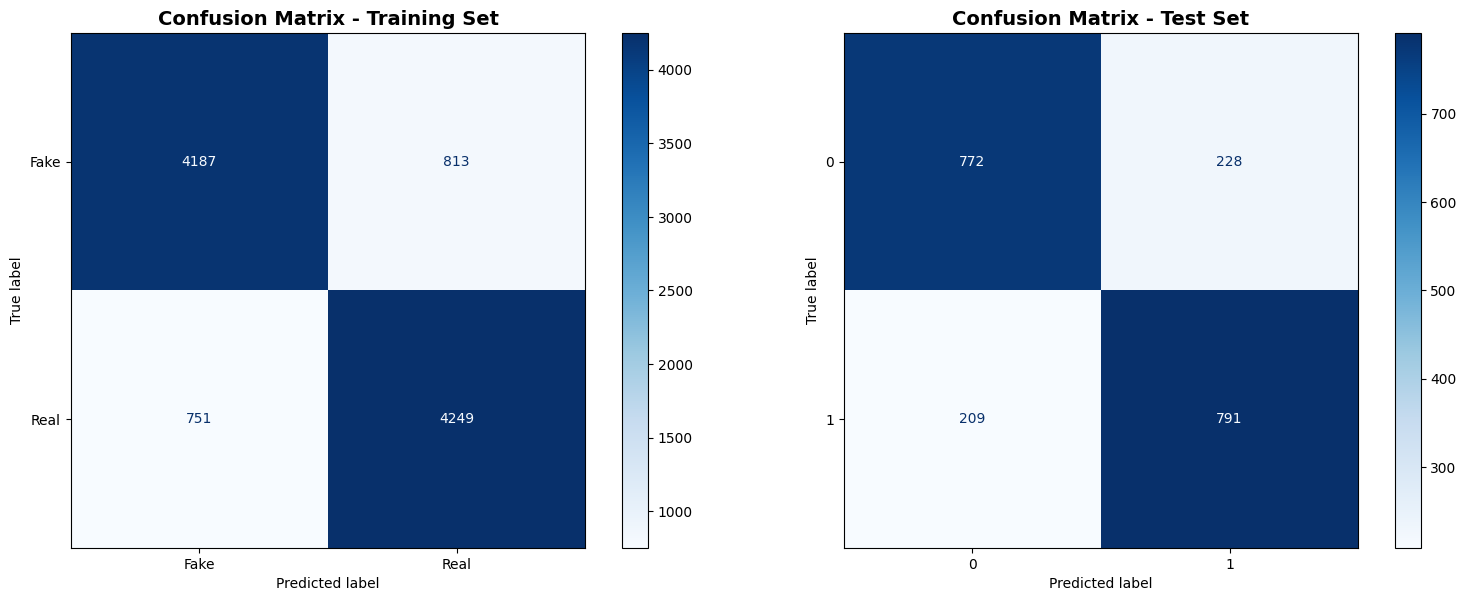

[CV] END ......................svm__C=10.0, svm__gamma=scale; total time=  22.5s
[CV] END .......................svm__C=10.0, svm__gamma=auto; total time=  26.6s
[CV] END ......................svm__C=10.0, svm__gamma=scale; total time=  22.5s
[CV] END .......................svm__C=10.0, svm__gamma=auto; total time=  26.9s
[CV] END .......................svm__C=1.0, svm__gamma=scale; total time=  23.2s
[CV] END .....................svm__C=100.0, svm__gamma=scale; total time=  27.5s


In [18]:
# Compute confusion matrices
cm_train = confusion_matrix(y_train_reduced, y_train_pred)
cm_test = confusion_matrix(y_test_reduced, y_test_pred)

# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Training confusion matrix
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=class_names)
disp_train.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title('Confusion Matrix - Training Set', fontsize=14, fontweight='bold')
axes[0].grid(False)

# Test confusion matrix
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test)
disp_test.plot(ax=axes[1], cmap='Blues', values_format='d')
axes[1].set_title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
axes[1].grid(False)

plt.tight_layout()
plt.show()